# Pre-processs meteo swiss grid:

## Setting up:

### Imports:

In [3]:
from pymatreader import read_mat
from matplotlib import pyplot as plt
import os
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd

# from tqdm import tqdm
from tqdm.notebook import tqdm
import re
from random import sample
from pathlib import Path
import logging
import xarray as xr
import pickl
import warnings
import re
import xgboost as xgb
import matplotlib.ticker as mtick
from itertools import chain, combinations, permutations
from calendar import monthrange

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV as RSCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import cftime

warnings.filterwarnings("ignore")

from scripts.xgb_helpers import *
from scripts.stakes_processing import *
from scripts.xgb_input import *
from scripts.xgb_model import *
from scripts.plots_clean import *
from scripts.xgb_metrics import *
from scripts.meteosuisse_preprocess import *

%load_ext autoreload
%autoreload 2

### Get glaciers and stakes:

In [4]:
# Get number of stakes per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of stakes
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes:', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)
glaciers = list(glStakes.keys())

# columns of interest in glamos data:
coi = [
    'vaw_id', 'sgi_id', 'rgi_id', 'glims_id', 'date_fix0', 'date_fix1', 'lat',
    'lon', 'height', 'b_a_fix', 'b_w_fix', 'aspect', 'slope', 'dis_from_border'
]
# glacier names:
glaciers = list(glStakes.keys())

Total number of stakes: 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]


Open one example:

In [5]:
ds = xr.open_dataset(path_prec +
                     'RhiresM_ch02.lonlat_196201010000_196212010000.nc',
                     decode_times=False)
units, reference_date = ds.time.attrs['units'].split('since')
start_date = pd.to_datetime(reference_date) + pd.DateOffset(months=ds.isel(
    time=0)['time'])
ds['time'] = pd.date_range(start=start_date,
                           periods=ds.sizes['time'],
                           freq='MS')
ds

<xarray.Dataset>
Dimensions:             (lon: 241, lat: 103, time: 12)
Coordinates:
  * lon                 (lon) float64 5.75 5.771 5.792 ... 10.71 10.73 10.75
  * lat                 (lat) float64 45.75 45.77 45.79 ... 47.83 47.85 47.88
  * time                (time) datetime64[ns] 1962-01-01 ... 1962-12-01
Data variables:
    longitude_latitude  float32 ...
    RhiresM             (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:

## MS data per stake:

### Monthly: create one assembled MS dataset for all years:


In [6]:
# Create one assembled MS dataset for all years
ms_year0 = 1961
ms_year1 = 2022

arrays = []
for year in tqdm(range(ms_year0, ms_year1), position=1, desc='year'):
    Ptemppr_monthly = createMS_monthly(
        year,
        path_meteogrid,
    )
    arrays.append(Ptemppr_monthly)

Pxr_full = xr.merge(arrays)

year:   0%|          | 0/61 [00:00<?, ?it/s]

#### Add 2022 and 2023:
Data format is different for these years so needs to be added separately

In [8]:
# Year 2022:
vars_ = ["t2m", "tp"]
sm_vars = ["TabsM", "RhiresM"]

Pxr_2022 = add_extremeYears(Pxr_full, sm_vars, vars_, year=2022)
Pxr_2023 = add_extremeYears(Pxr_full, sm_vars, vars_, year=2023)

# Add 2022 and 2023 to full Pxr
Pxr_full = xr.merge([Pxr_full, Pxr_2022, Pxr_2023]).sortby('time')
Pxr_full.to_netcdf(
    "../../data/MB_modeling/MeteoSuisse/Pxr_full.nc")  # save to file
Pxr_full

<xarray.Dataset>
Dimensions:  (lon: 241, lat: 103, time: 753)
Coordinates:
  * lon      (lon) float64 5.75 5.771 5.792 5.812 ... 10.69 10.71 10.73 10.75
  * lat      (lat) float64 45.75 45.77 45.79 45.81 ... 47.81 47.83 47.85 47.88
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 2023-09-01
Data variables:
    t2m      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    tp       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...

### Create one DF per stake:

In [15]:
# Get surface height of stakes and era5/MS grid:
stake_grid_alt, stake_alt = getSurfaceHeight(glStakes.keys(),
                                             glStakes,
                                             input_type='MeteoSuisse')

dTdz_stakes = getTemperatureGradients(glStakes.keys(), glStakes)

glaciers:   0%|          | 0/21 [00:00<?, ?it/s]

In [18]:
! ls ../../data/MB_modeling/MeteoSuisse/TabsD_verified/lonlat/


TabsD_ch02.lonlat_196101010000_196112310000.nc
TabsD_ch02.lonlat_196201010000_196212310000.nc
TabsD_ch02.lonlat_196301010000_196312310000.nc
TabsD_ch02.lonlat_196401010000_196412310000.nc
TabsD_ch02.lonlat_196501010000_196512310000.nc
TabsD_ch02.lonlat_196601010000_196612310000.nc
TabsD_ch02.lonlat_196701010000_196712310000.nc
TabsD_ch02.lonlat_196801010000_196812310000.nc
TabsD_ch02.lonlat_196901010000_196912310000.nc
TabsD_ch02.lonlat_197001010000_197012310000.nc
TabsD_ch02.lonlat_197101010000_197112310000.nc
TabsD_ch02.lonlat_197201010000_197212310000.nc
TabsD_ch02.lonlat_197301010000_197312310000.nc
TabsD_ch02.lonlat_197401010000_197412310000.nc
TabsD_ch02.lonlat_197501010000_197512310000.nc
TabsD_ch02.lonlat_197601010000_197612310000.nc
TabsD_ch02.lonlat_197701010000_197712310000.nc
TabsD_ch02.lonlat_197801010000_197812310000.nc
TabsD_ch02.lonlat_197901010000_197912310000.nc
TabsD_ch02.lonlat_198001010000_198012310000.nc
TabsD_ch02.lonlat_198101010000_198112310000.nc
TabsD_ch02.lo

In [19]:
%%time
# Assemble MeteoSuisse data for all stakes:
glaciers = list(glStakes.keys())

path_save_MS = '../../data/MB_modeling/MeteoSuisse/stakes/'
path_save_MS_full = '../../data/MB_modeling/MeteoSuisse/stakes_full/'
path_MS_daily = '../../data/MB_modeling/MeteoSuisse/TabsD_verified/lonlat/'

createPath(path_save_MS)
createPath(path_save_MS_full)

preprocessMS = True
if preprocessMS:
    emptyfolder(path_save_MS)

    for gl in tqdm(glStakes.keys(), desc='glaciers', position=1):
        for stake in glStakes[gl]:
            fileName = re.split('.csv', stake)[0]
            stakeName = re.split(".csv", stake)[0][:-3]
            # Get coordinates and time of file for this stake:
            df_stake = read_stake_csv(path_glacattr, stake)

            # Create corresponding Meteo swiss xr
            stake_lat = np.mean(df_stake.lat.unique())
            stake_lon = np.mean(df_stake.lon.unique())

            # print('Stake coordinates:', stake_lat, stake_lon)

            stake_year0 = df_stake.date_fix0.iloc[0].year
            stake_year1 = df_stake.date_fix1.iloc[-1].year

            # overlapping with PMB data
            Pxr_stake = createInputMS(stake_lat,
                                      stake_lon,
                                      stake_year0,
                                      stake_year1,
                                      Pxr_full,
                                      stakeName,
                                      stake_alt,
                                      stake_grid_alt,
                                      dTdz_stakes,
                                      full=False)

            save_name = path_save_MS + f"{fileName}_full.nc"
            Pxr_stake.to_netcdf(save_name)

            # full from 1961 (for gap filling)
            Pxr_stake = createInputMS(stake_lat,
                                      stake_lon,
                                      stake_year0,
                                      stake_year1,
                                      Pxr_full,
                                      stakeName,
                                      stake_alt,
                                      stake_grid_alt,
                                      dTdz_stakes,
                                      full=True)

            save_name = path_save_MS_full + f"{fileName}_full.nc"
            Pxr_stake.to_netcdf(save_name)

glaciers:   0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 6min 36s, sys: 1min, total: 7min 37s
Wall time: 13min 19s


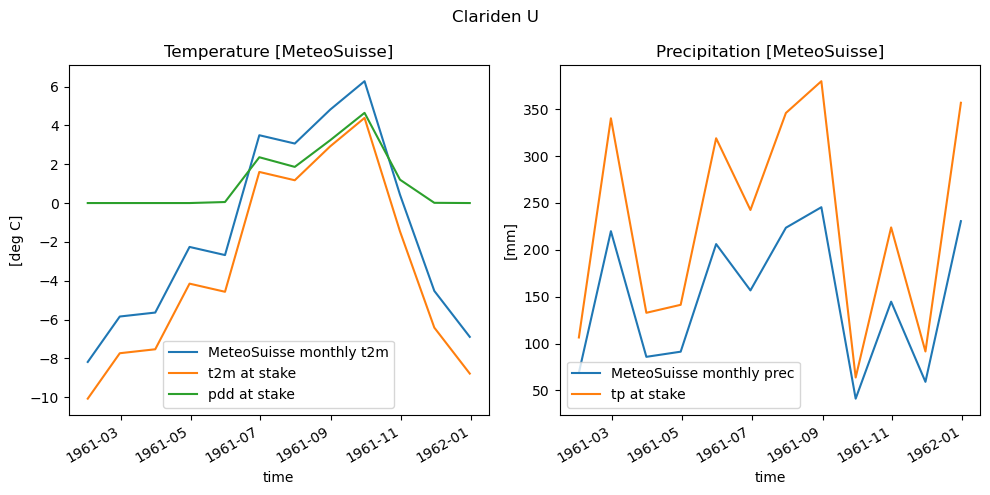

In [20]:
# Example
Pxr_stake = xr.open_dataset(path_save_MS + f"clariden_U_mb_full.nc")
Pxr_stake_year = Pxr_stake.sel(
    time=pd.date_range('1961-01-31', '1961-12-31', freq='M'))

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
Pxr_stake_year.t2m.plot(ax=ax, label='MeteoSuisse monthly t2m')
Pxr_stake_year.t2m_corr.plot(ax=ax, label="t2m at stake")
Pxr_stake_year.pdd.plot(ax=ax, label="pdd at stake")
ax.set_title(f'Temperature [{"MeteoSuisse"}]')
ax.set_ylabel('[deg C]')
ax.legend()

ax = plt.subplot(1, 2, 2)
Pxr_stake_year.tp.plot(ax=ax, label='MeteoSuisse monthly prec')
Pxr_stake_year.tp_corr.plot(ax=ax, label="tp at stake")

ax.set_title(f'Precipitation [{"MeteoSuisse"}]')
ax.set_ylabel('[mm]')
ax.legend()
plt.suptitle('Clariden U')
plt.tight_layout()

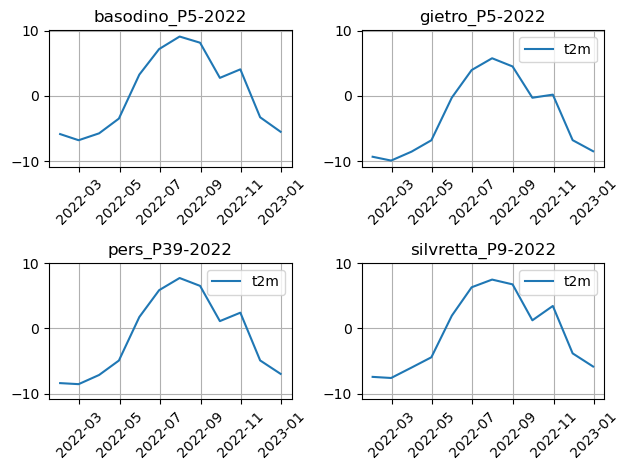

In [21]:
# Example:
stakes = ['basodino_P5', 'gietro_P5', 'pers_P39', 'silvretta_P9']
year = 2022
M, N = 2, 2

ax1 = plt.subplot(M, N, 1)
prtemp_xr = xr.open_dataset(path_save_MS + f"{stakes[0]}_mb_full.nc")
xrtemppr_one_year = prtemp_xr.sel(time=slice(f'{year}-01-31', f'{year}-12-31'))
ax1.plot(xrtemppr_one_year.time, xrtemppr_one_year.t2m, label='t2m')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
# ax1.plot(xrtemppr_one_year.time, xrtemppr_one_year.pdd, label='pdd')
ax1.set_title(f'{stakes[0]}-{year}')
ax1.grid()

for i, stake in enumerate(stakes[1:]):
    ax = plt.subplot(M, N, i + 2, sharey=ax1)
    prtemp_xr = xr.open_dataset(path_save_MS + f"{stake}_mb_full.nc")
    xrtemppr_one_year = prtemp_xr.sel(
        time=slice(f'{year}-01-31', f'{year}-12-31'))
    ax.plot(xrtemppr_one_year.time, xrtemppr_one_year.t2m, label='t2m')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # ax.plot(xrtemppr_one_year.time, xrtemppr_one_year.pdd, label='pdd')
    ax.set_title(f'{stake}-{year}')
    ax.legend()
    ax.grid()
plt.tight_layout()

## Daily: assemble daily 2022 and 2023 data

In [22]:
daily_extremeYears(year=2022)
daily_extremeYears(year=2023)

Save TabsD_ch02.lonlat_202201010000_202212310000.nc to : ../../data/MB_modeling/MeteoSuisse//TabsD_verified/lonlat/
Save RhiresD_ch02.lonlat_202201010000_202212310000.nc to : ../../data/MB_modeling/MeteoSuisse/RhiresD_verified/lonlat/
Save TabsD_ch02.lonlat_202301010000_202312310000.nc to : ../../data/MB_modeling/MeteoSuisse//TabsD_verified/lonlat/
Save RhiresD_ch02.lonlat_202301010000_202312310000.nc to : ../../data/MB_modeling/MeteoSuisse/RhiresD_verified/lonlat/


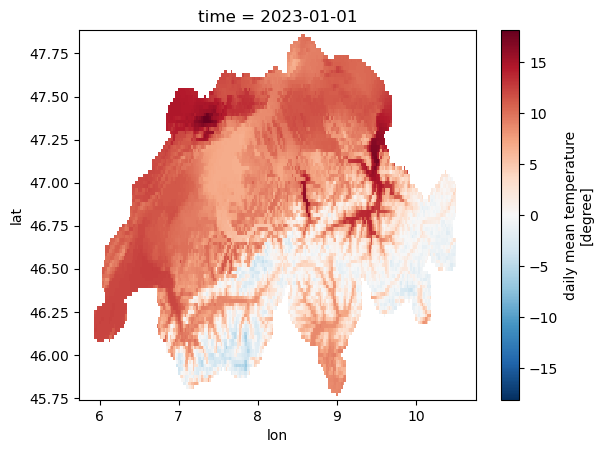

In [23]:
# Example
xr.open_dataset(
    '../../data/MB_modeling/MeteoSuisse//TabsD_verified/lonlat/TabsD_ch02.lonlat_202301010000_202312310000.nc'
).isel(time=0).TabsD.plot()

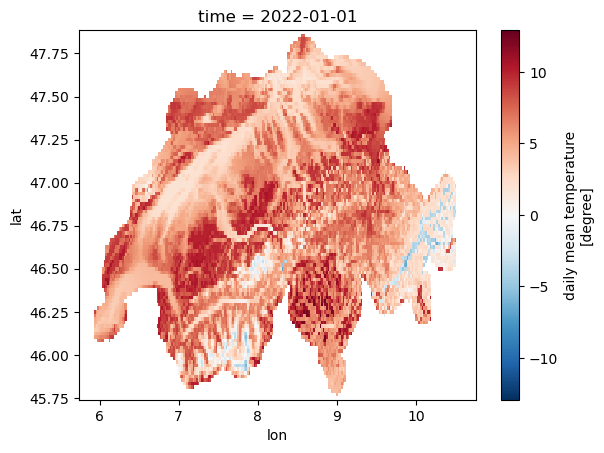

In [24]:
# Example
xr.open_dataset(
    '../../data/MB_modeling/MeteoSuisse//TabsD_verified/lonlat/TabsD_ch02.lonlat_202201010000_202212310000.nc'
).isel(time=0).TabsD.plot()